<a href="https://colab.research.google.com/github/vincelemke99/Bachelor-Thesis/blob/main/finished2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [269]:
#!pip install pandas category_encoders scikit-learn tensorflow --q


In [270]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Import machine learning libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

In [271]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

Authenticated


In [272]:
PROJECT_ID = 'prj-snd-ew3-vschmitt'

In [273]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

In [274]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'lead_prediction'
BQ_TABLE = 'trainings_data'

In [275]:
# SQL query to select data
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""

try:
    # Execute the query and convert the result to a pandas DataFrame
    df = client.query(query=query).to_dataframe()
    print("Query executed successfully and DataFrame is ready.")
except Exception as e:
    print(f"An error occurred: {e}")

Query executed successfully and DataFrame is ready.


In [276]:
df.shape

(210811, 18)

In [277]:
df.head()

,Lead_ID,Lead_Source,Lead_Source_Detail,Name_Case,Domain_Type,Gender,Host,has_Phone,Accept_Data_Policy,Conversion_Type,Study_Model,Type_of_Study_Program,Study_Location,Faculty,Study_Program,Semester,is_converted,Sum_of_Study_Interests
0,00Q7U000003RdpLUAS,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,Berlin,Fachbereich Design,Styling,Wintersemester,False,1
1,00Q7U000005NeSiUAK,Organisch,Bing,lowercase,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,False,1
2,00Q7U0000034VNWUA2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
3,00Q7U000006uQDGUA2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
4,00Q7U000008l7alUAA,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,True,1


In [278]:
df.drop(['Lead_ID',], axis="columns", inplace=True)

In [279]:
df.rename(columns={'Lead_Source' : 'Lead Source', 'Lead_Source_Detail' : 'Lead Source Detail',
                   'Name_Case' : 'Name Case', 'has_Phone' : 'has Phone', 'Accept_Data_Policy' : 'Accept Data Policy',
                   'Conversion_Type' : 'Conversion Type', 'Study_Model' : 'Study Model', 'Type_of_Study_Program' : 'Type of Study Program',
                   'Study_Location' : 'Study Location', 'Study_Program' : 'Study Program', 'Sum_of_Study_Interests' : 'Sum of Study Interests' , 'Domain_Type' : 'Domain Type' },inplace=True)


In [280]:
df.head()

,Lead Source,Lead Source Detail,Name Case,Domain Type,Gender,Host,has Phone,Accept Data Policy,Conversion Type,Study Model,Type of Study Program,Study Location,Faculty,Study Program,Semester,is_converted,Sum of Study Interests
0,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,Berlin,Fachbereich Design,Styling,Wintersemester,False,1
1,Organisch,Bing,lowercase,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,False,1
2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
3,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
4,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,True,1


In [281]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Host,40591
Conversion Type,39412
Gender,3738
Type of Study Program,0
is_converted,0
Semester,0
Study Program,0
Faculty,0
Study Location,0
Lead Source,0


In [282]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
Host,19.254688
Conversion Type,18.695419
Gender,1.773152
Type of Study Program,0.000000
is_converted,0.000000
Semester,0.000000
Study Program,0.000000
Faculty,0.000000
Study Location,0.000000
Lead Source,0.000000


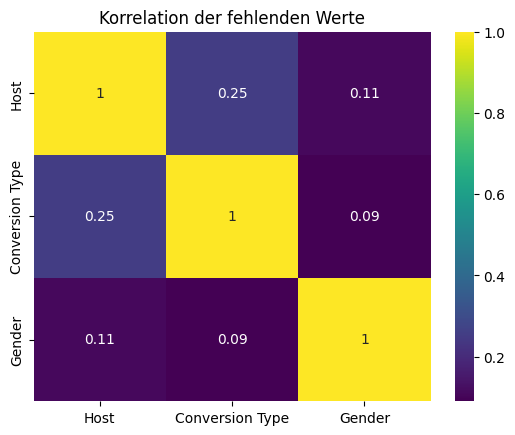

In [283]:
# Korrelation zwischen den fehlenden Werten
correlation_matrix = df[['Host', 'Conversion Type', 'Gender']].isnull().corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Korrelation der fehlenden Werte')
plt.show()


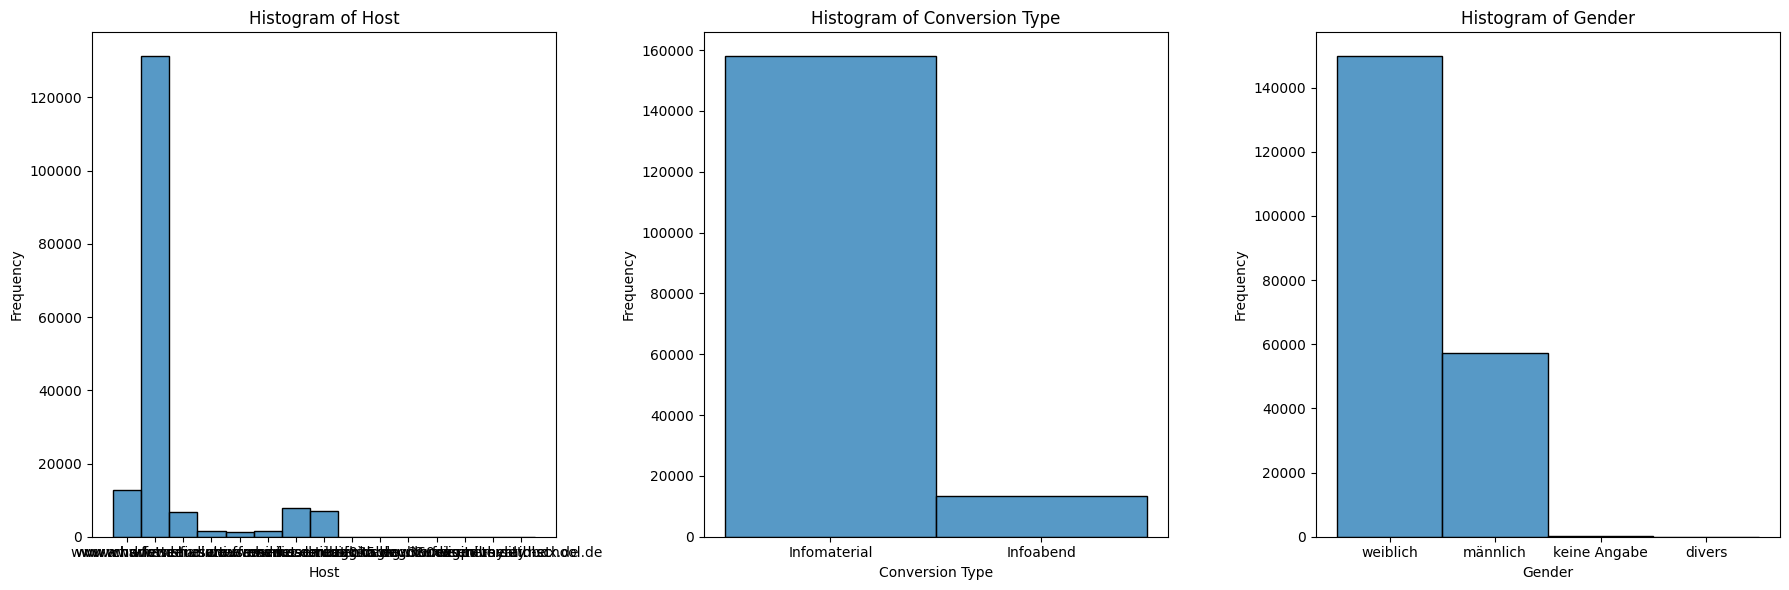

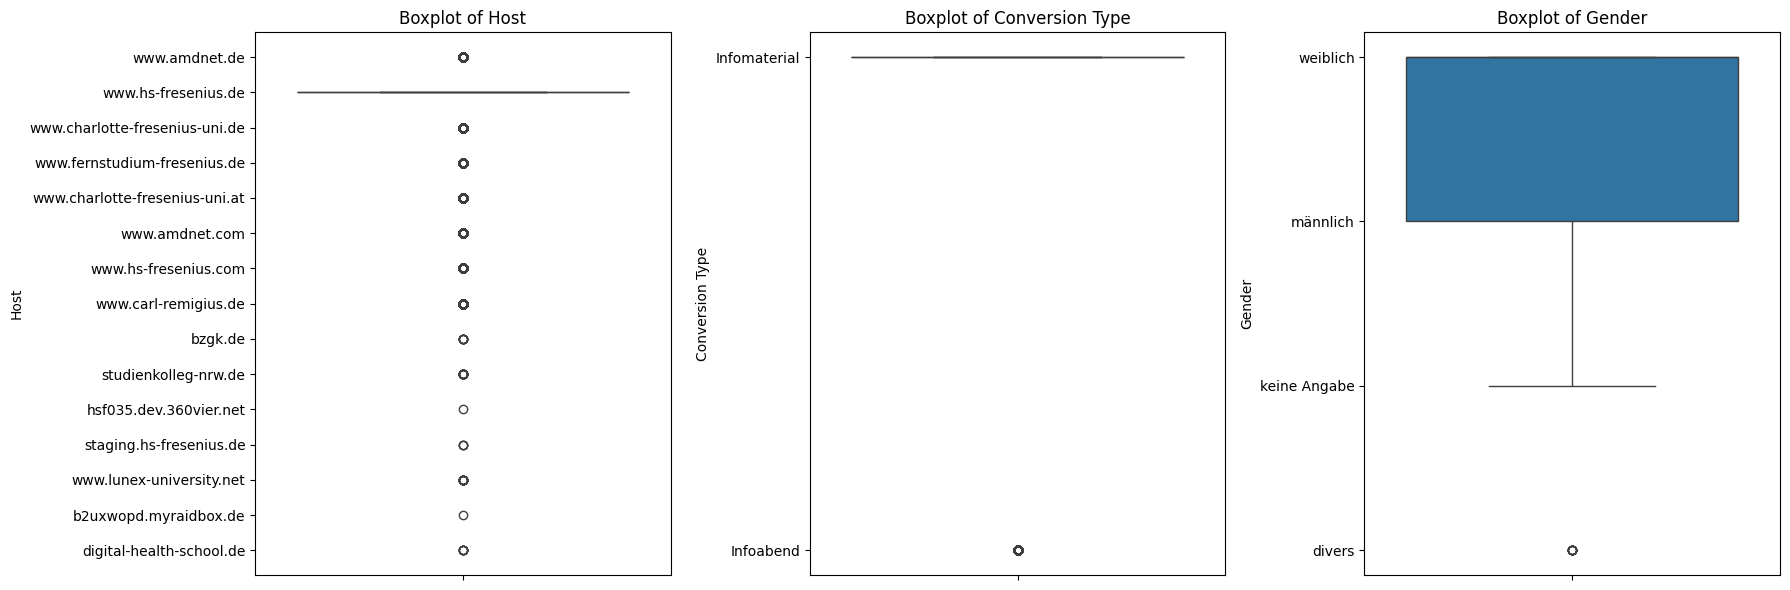

In [284]:
# Histogramme
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, column in enumerate(['Host', 'Conversion Type', 'Gender']):
    sns.histplot(df[column], kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, column in enumerate(['Host', 'Conversion Type', 'Gender']):
    sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

In [285]:
df['Host'].value_counts()

Host
www.hs-fresenius.de               131236
www.amdnet.de                      12679
www.hs-fresenius.com                7917
www.carl-remigius.de                7067
www.charlotte-fresenius-uni.de      6886
www.amdnet.com                      1578
www.fernstudium-fresenius.de        1503
www.charlotte-fresenius-uni.at      1297
studienkolleg-nrw.de                  23
www.lunex-university.net              16
bzgk.de                                7
digital-health-school.de               6
staging.hs-fresenius.de                3
hsf035.dev.360vier.net                 1
b2uxwopd.myraidbox.de                  1
Name: count, dtype: int64

In [286]:
unwanted_hosts = ['staging.hs-fresenius.de', 'hsf035.dev.360vier.net', 'b2uxwopd.myraidbox.de', 'digital-health-school.de']

# Filter the DataFrame
df = df[~df['Host'].isin(unwanted_hosts)]

In [287]:
unwanted_Lead_Source = ['-149307507Publisher', 'Not Found']

# Filter the DataFrame
df = df[~df['Lead Source'].isin(unwanted_Lead_Source )]

In [288]:
df['Conversion Type'] = df['Conversion Type'].fillna('Infomaterial')

In [289]:
df['Gender'] = df['Gender'].fillna('weiblich')

In [290]:
df['Host'] = df['Host'].fillna('www.hs-fresenius.de')

In [291]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
Lead Source,0.0
Study Model,0.0
is_converted,0.0
Semester,0.0
Study Program,0.0
Faculty,0.0
Study Location,0.0
Type of Study Program,0.0
Conversion Type,0.0
Lead Source Detail,0.0


In [292]:
df.describe()

,Sum of Study Interests
count,210797.0
mean,1.05613
std,0.279028
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,16.0


In [293]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Lead Source,0
Study Model,0
is_converted,0
Semester,0
Study Program,0
Faculty,0
Study Location,0
Type of Study Program,0
Conversion Type,0
Lead Source Detail,0


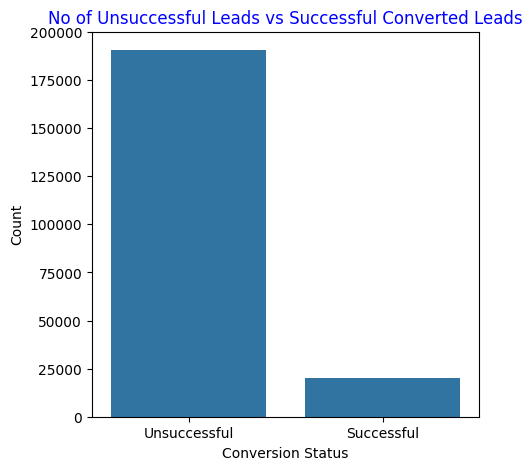

In [294]:
plt.figure(figsize=(5,5))
sns.countplot(x='is_converted', data=df)
plt.title('No of Unsuccessful Leads vs Successful Converted Leads', color='blue')
plt.xticks(np.arange(2), ('Unsuccessful', 'Successful'))
plt.xlabel('Conversion Status')
plt.ylabel('Count')
plt.show()

In [295]:
total_leads = len(df)
successful_leads = df['is_converted'].sum()
conversion_rate = (successful_leads / total_leads) * 100
print(f'Conversion Rate: {conversion_rate:.2f}%')

Conversion Rate: 9.60%


In [296]:
# Creating a crosstab DataFrame for demonstration
crosstab_df = pd.crosstab(index=df['Lead Source'], columns='count')

In [297]:
def plot_frequency_and_percentage(feature, df, category_df, another_row=False, height=8, ylabels=[]):
    if another_row:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, height * 2))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Get top 5 categories by frequency
    top_categories = category_df[feature].value_counts().nlargest(5).index

    # Frequency plot for top 5 categories
    ax1.set_title(f'Frequency Plot of {feature}', color='blue')
    ax1.set_ylabel(feature)
    ax1.set_xlabel('count')
    sns.countplot(y=feature, data=category_df[category_df[feature].isin(top_categories)],
                  order=top_categories, ax=ax1, color='green')
    if ylabels:
        ax1.set_yticklabels(ylabels)

    # Calculate count of converted leads for top 5 categories
    converted_counts = df[df['is_converted'] == True][feature].value_counts()
    converted_counts = converted_counts[converted_counts.index.isin(top_categories)]

    # Converted leads plot for top 5 categories
    ax2.set_title('Converted Leads Count', color='blue')
    ax2.set_ylabel(feature)
    ax2.set_xlabel('count')
    converted_counts.sort_values().plot(kind='barh', ax=ax2, color='orange')
    if ylabels:
        ax2.set_yticklabels(ylabels)

    # Calculate and display overall conversion rate
    total_leads = len(df)
    successful_leads = df['is_converted'].sum()
    conversion_rate = (successful_leads / total_leads) * 100
    fig.suptitle(f'Overall Conversion Rate: {conversion_rate:.2f}%', fontsize=14, color='red')


plt.show()

In [298]:

def plot_conversion_rate(df, is_converted_column, feature):
    """
    Plots the conversion rate for a specified feature.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    is_converted_column (str): The name of the column indicating if a conversion occurred.
    feature (str): The feature for which to calculate and plot the conversion rate.
    """
    # Filter data where is_converted is True
    df_converted = df[df[is_converted_column] == True]

    # Calculate the count of conversions for each unique value in the feature
    converted_counts = df_converted[feature].value_counts()

    # Calculate the percentage of each unique value within the converted data
    conversion_rate = (converted_counts / converted_counts.sum()) * 100
    conversion_rate = conversion_rate.sort_values(ascending=False)

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    conversion_rate.plot(kind='bar')
    plt.title(f'Percentage of Converted Users by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Percentage of Converted Users (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

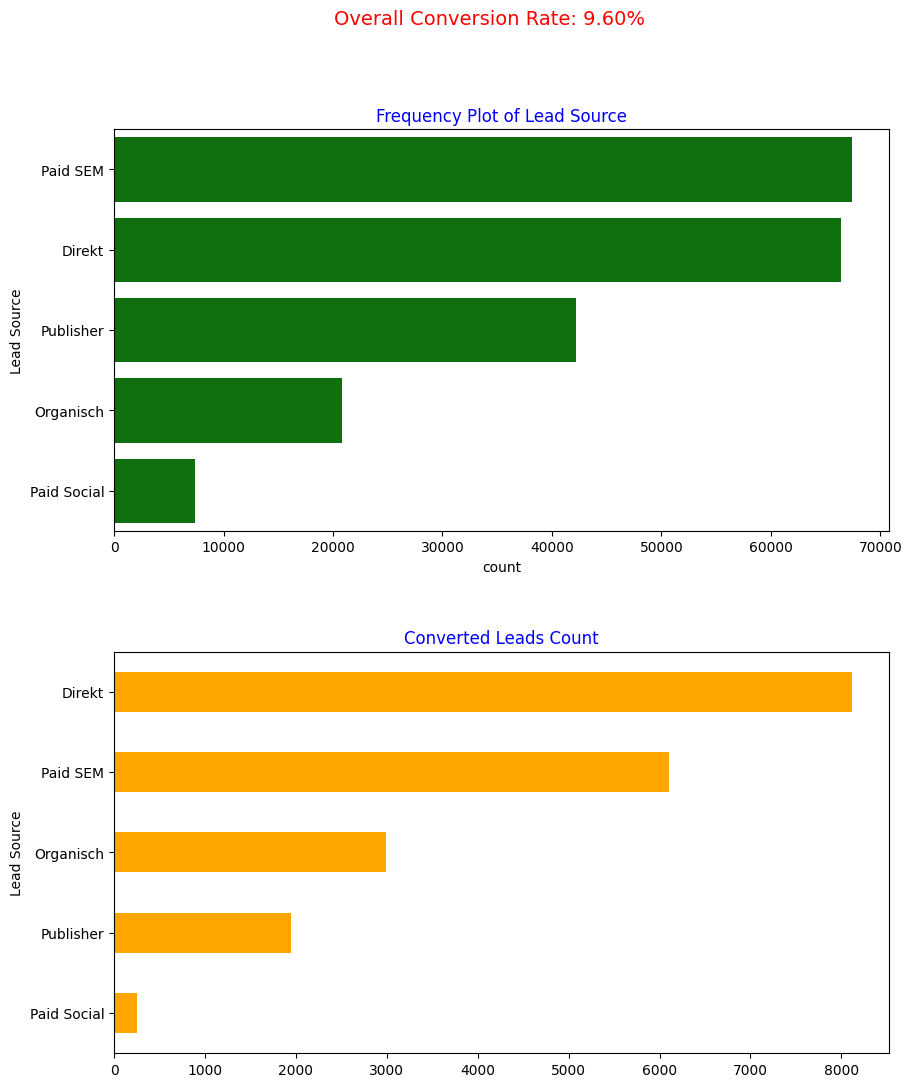

In [299]:
plot_frequency_and_percentage('Lead Source', df, df, True, 6)

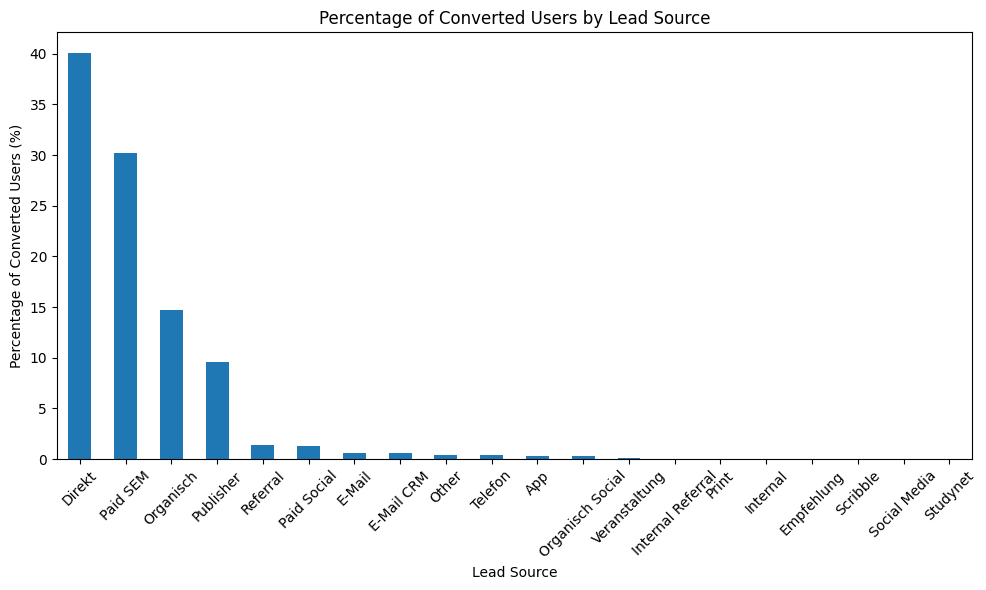

In [300]:
plot_conversion_rate(df, 'is_converted', 'Lead Source')

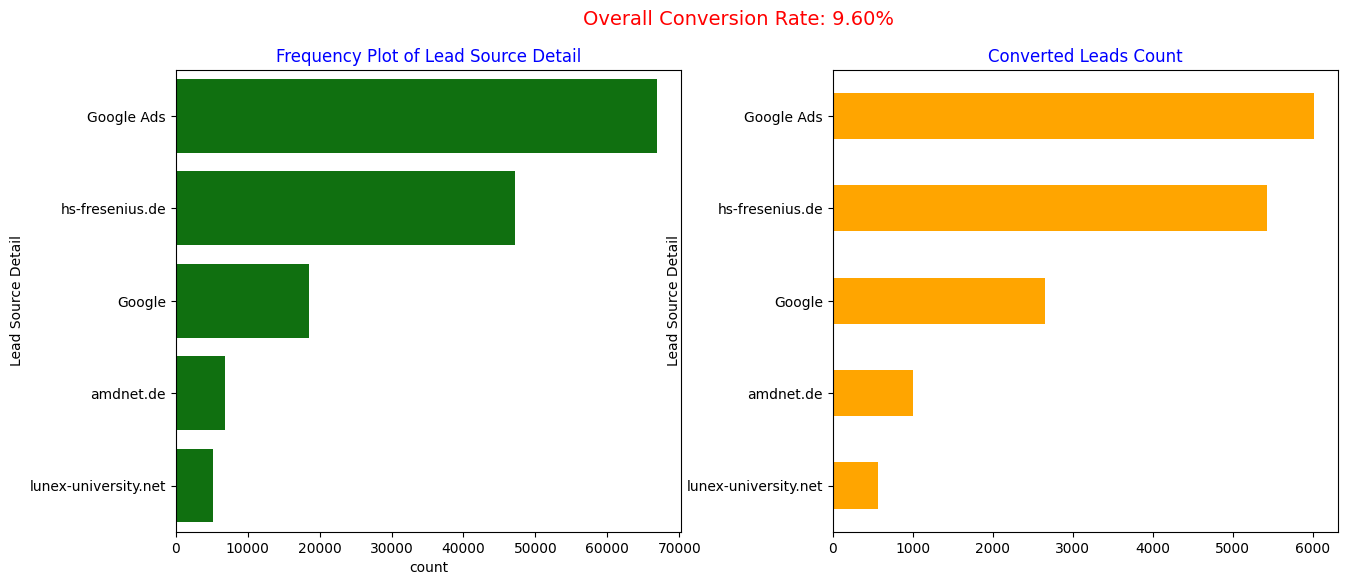

In [301]:
#plot_frequency_and_percentage('Lead_Source_Detail', df, df, True, 6)
plot_frequency_and_percentage('Lead Source Detail', df, df, another_row=False, height=8, ylabels=[])

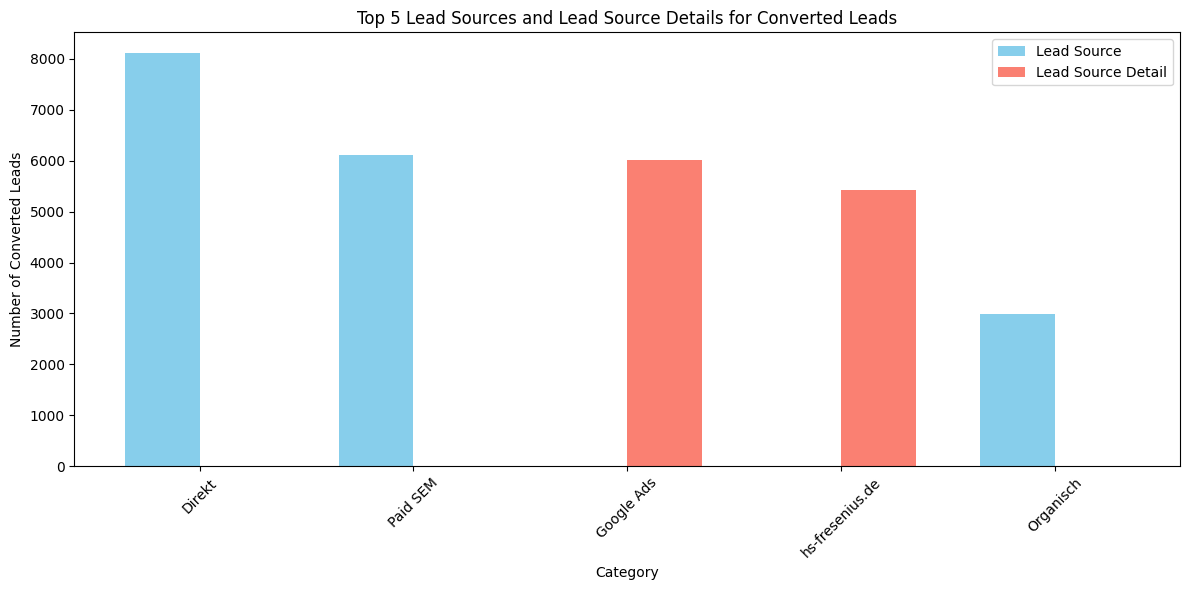

In [302]:
# Filter for converted leads
converted_leads = df[df['is_converted'] == True]

# Aggregate the data for Lead Source and Lead Source Detail
lead_source_counts = converted_leads['Lead Source'].value_counts()
lead_source_detail_counts = converted_leads['Lead Source Detail'].value_counts()

# Combine the counts into a DataFrame
combined_counts = pd.concat([lead_source_counts, lead_source_detail_counts], axis=1).fillna(0)
combined_counts.columns = ['Lead Source', 'Lead Source Detail']

# Select the top 5 categories overall
top_combined_counts = combined_counts.sum(axis=1).nlargest(5)
top_combined_counts = combined_counts.loc[top_combined_counts.index]

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = range(len(top_combined_counts))

# Plot Lead Source bars
lead_source_bars = ax.bar(index, top_combined_counts['Lead Source'], bar_width, label='Lead Source', color='skyblue')

# Plot Lead Source Detail bars next to Lead Source bars
lead_source_detail_bars = ax.bar([i + bar_width for i in index], top_combined_counts['Lead Source Detail'], bar_width, label='Lead Source Detail', color='salmon')

# Add labels, title, and legend
ax.set_xlabel('Category')
ax.set_ylabel('Number of Converted Leads')
ax.set_title('Top 5 Lead Sources and Lead Source Details for Converted Leads')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(top_combined_counts.index, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

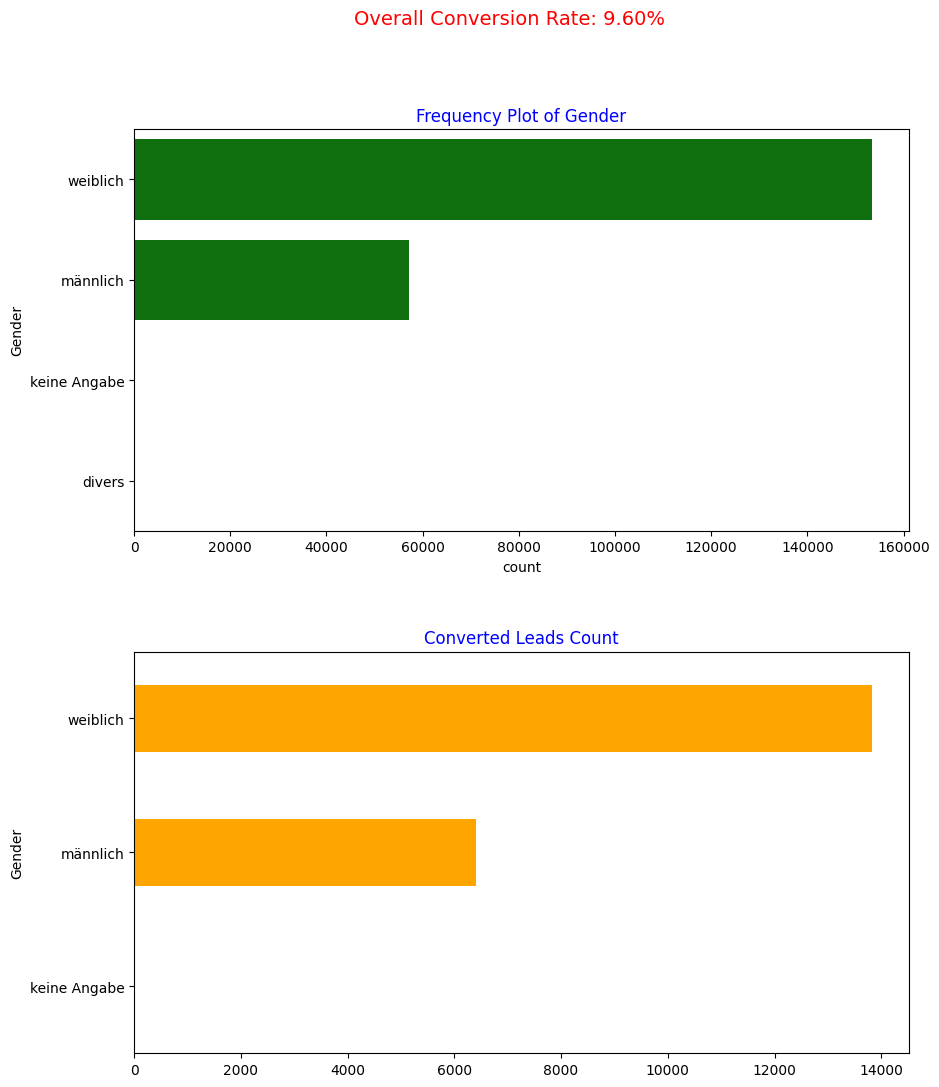

In [303]:
plot_frequency_and_percentage('Gender', df, df, True, 6)

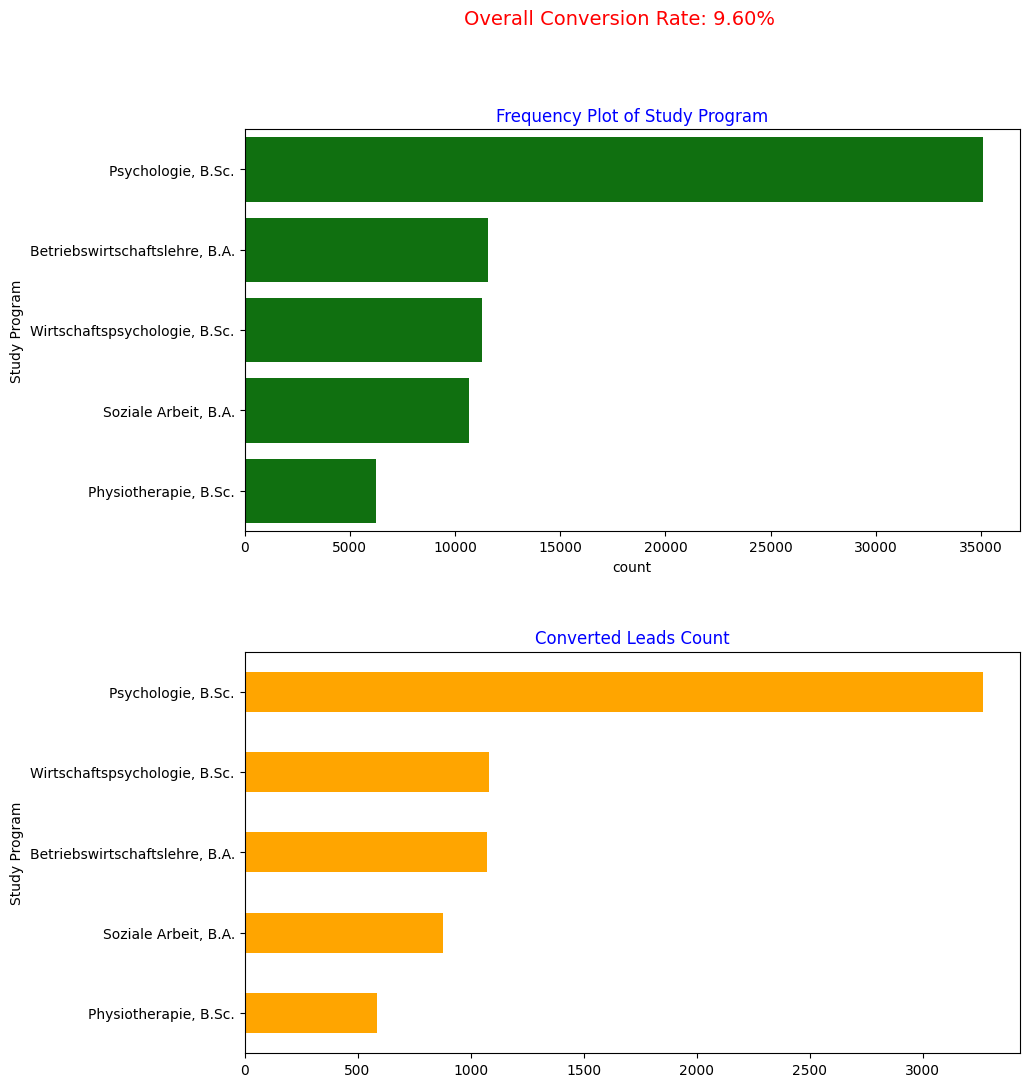

In [304]:
plot_frequency_and_percentage('Study Program', df, df, True, 6)

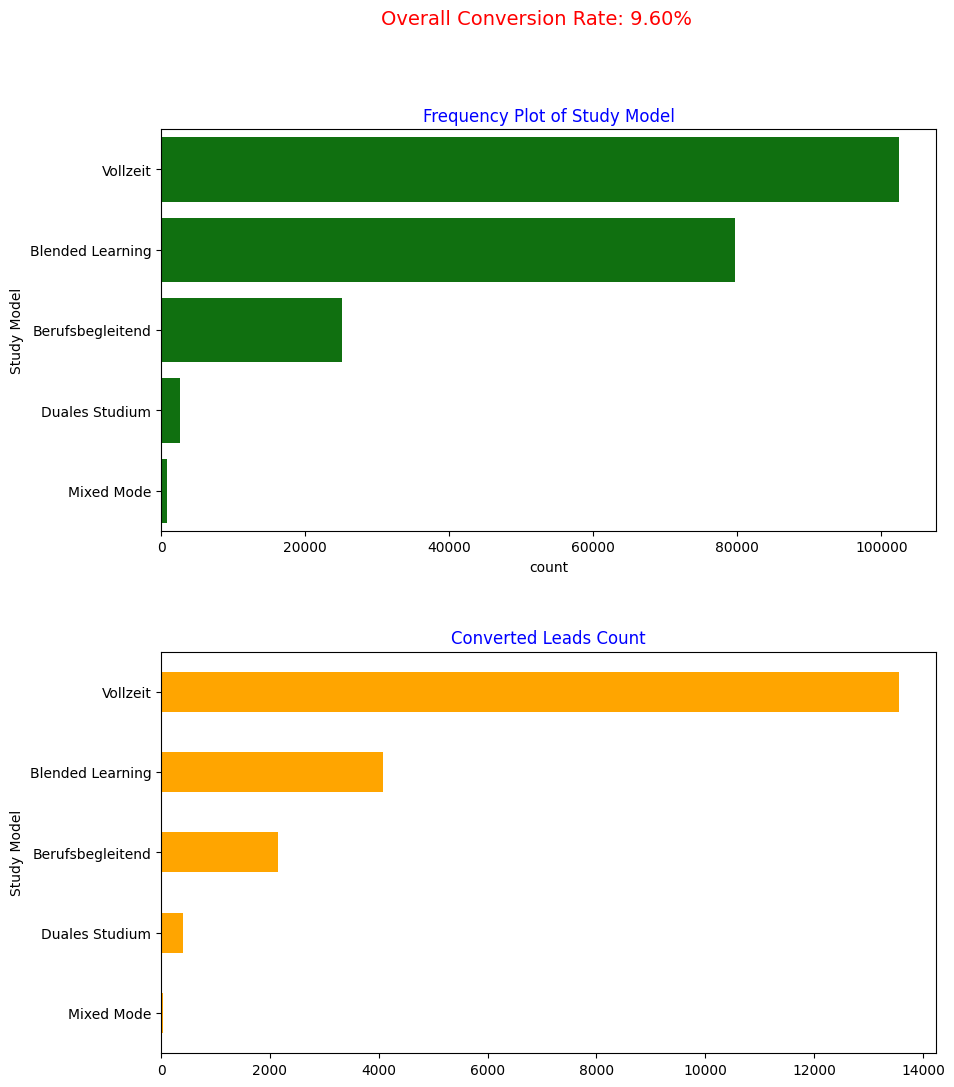

In [305]:
plot_frequency_and_percentage('Study Model', df, df, True, 6)

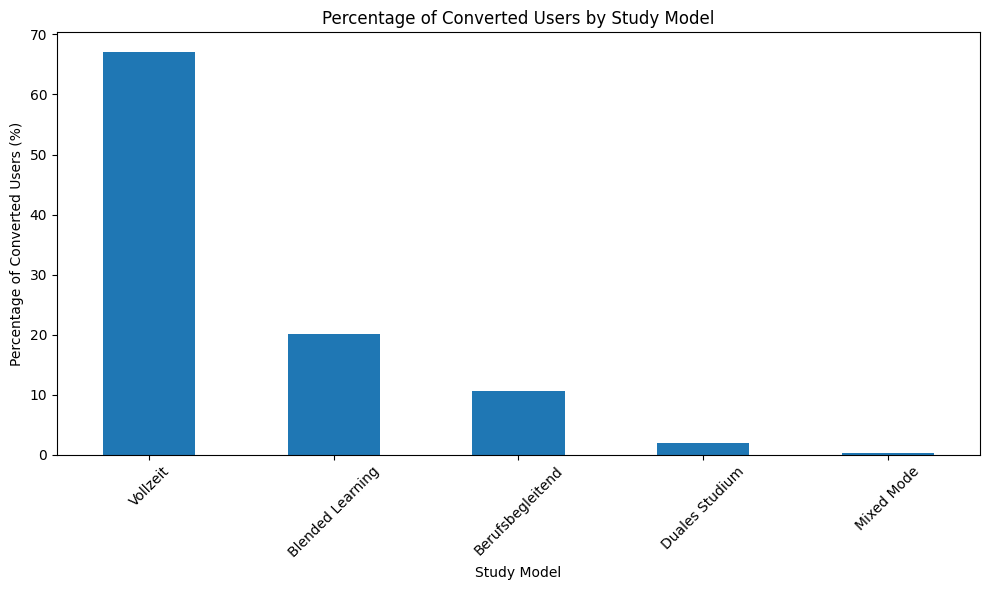

In [306]:
plot_conversion_rate(df, 'is_converted', 'Study Model')

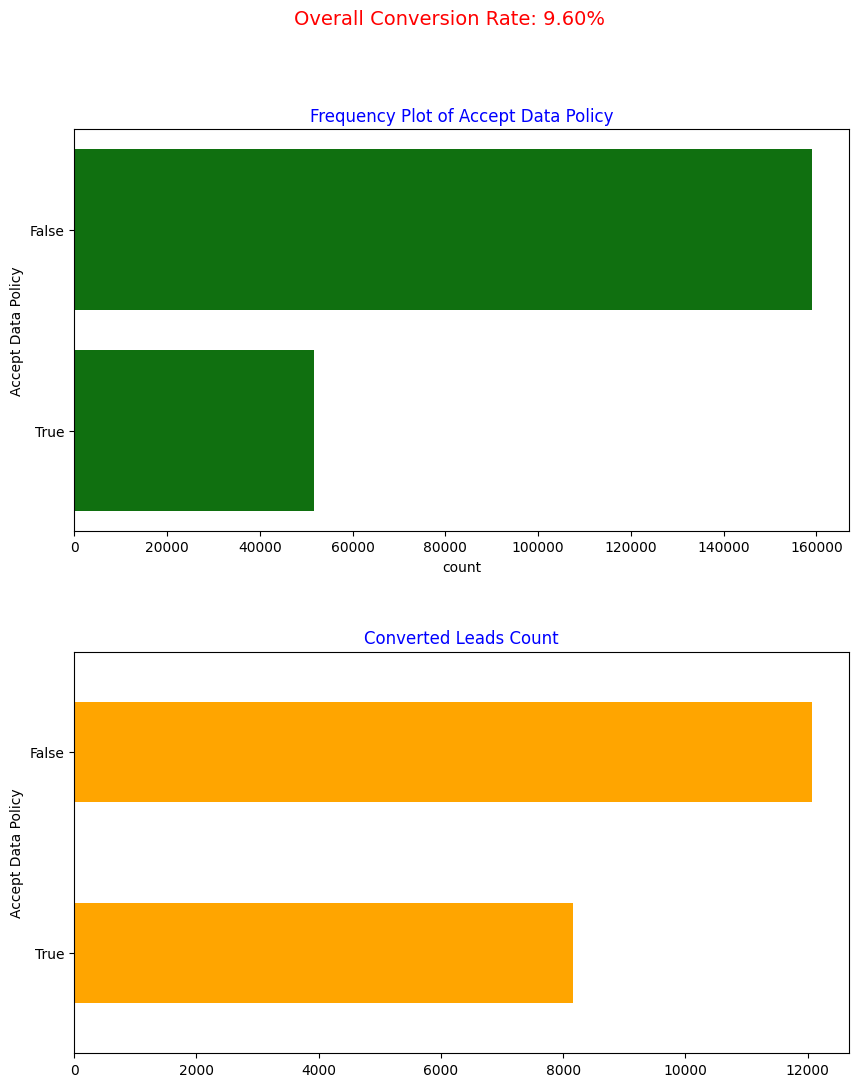

In [307]:
plot_frequency_and_percentage('Accept Data Policy', df, df, True, 6)

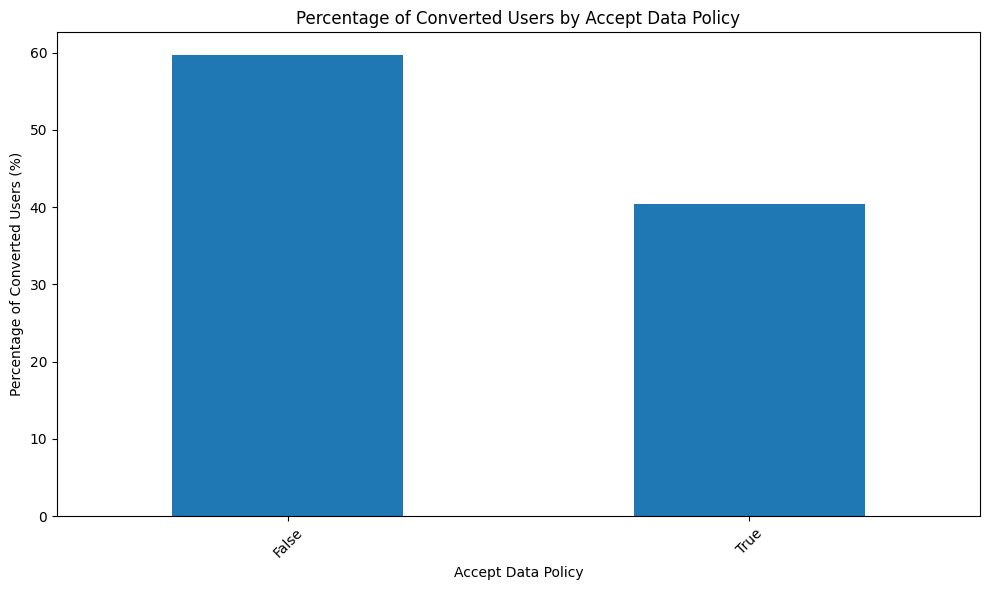

In [308]:
plot_conversion_rate(df, 'is_converted', 'Accept Data Policy')

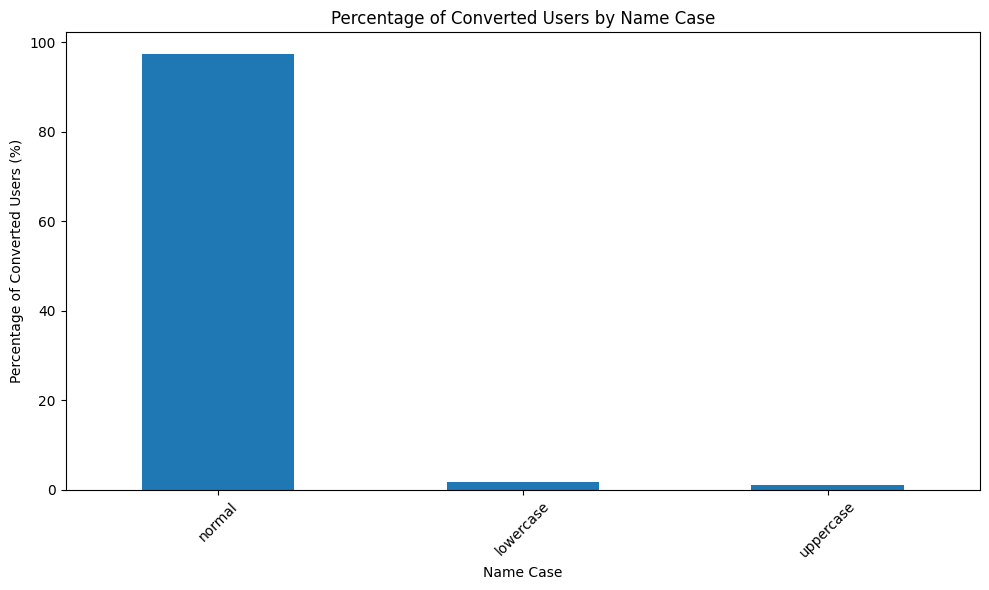

In [309]:
plot_conversion_rate(df, 'is_converted', 'Name Case')

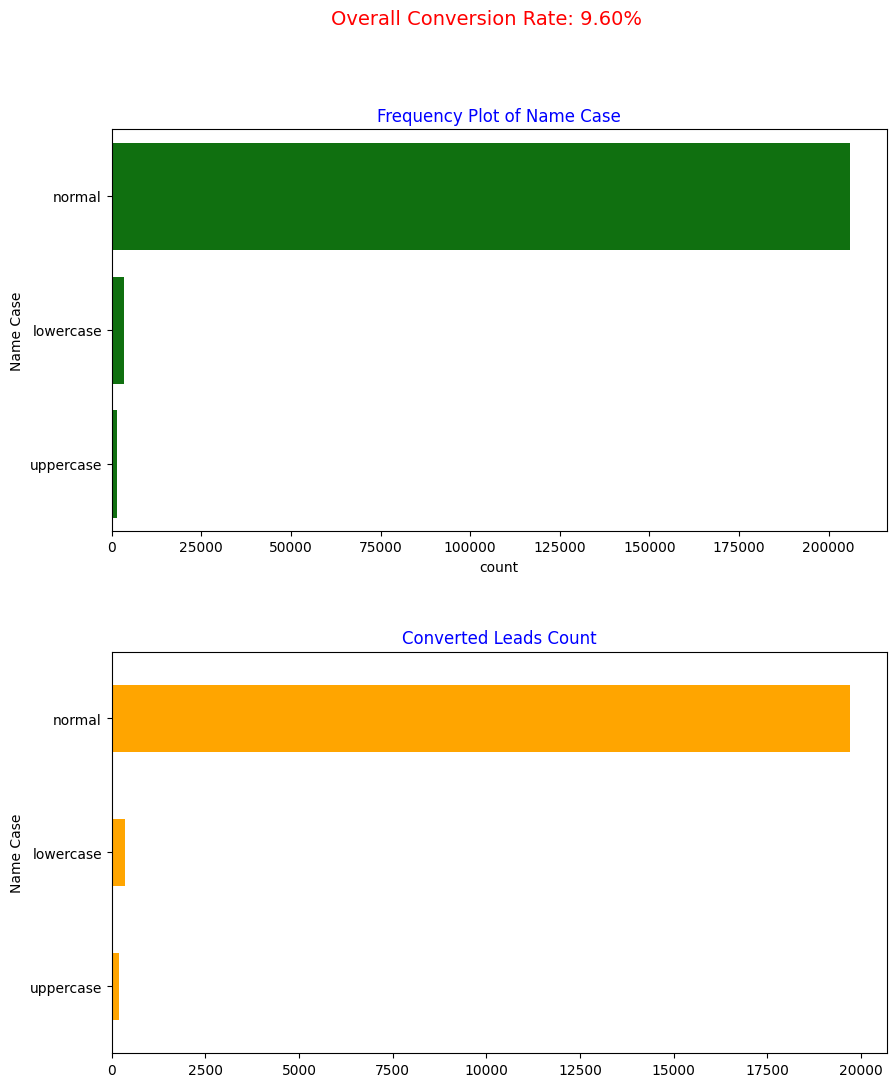

In [310]:
plot_frequency_and_percentage('Name Case', df, df, True, 6)

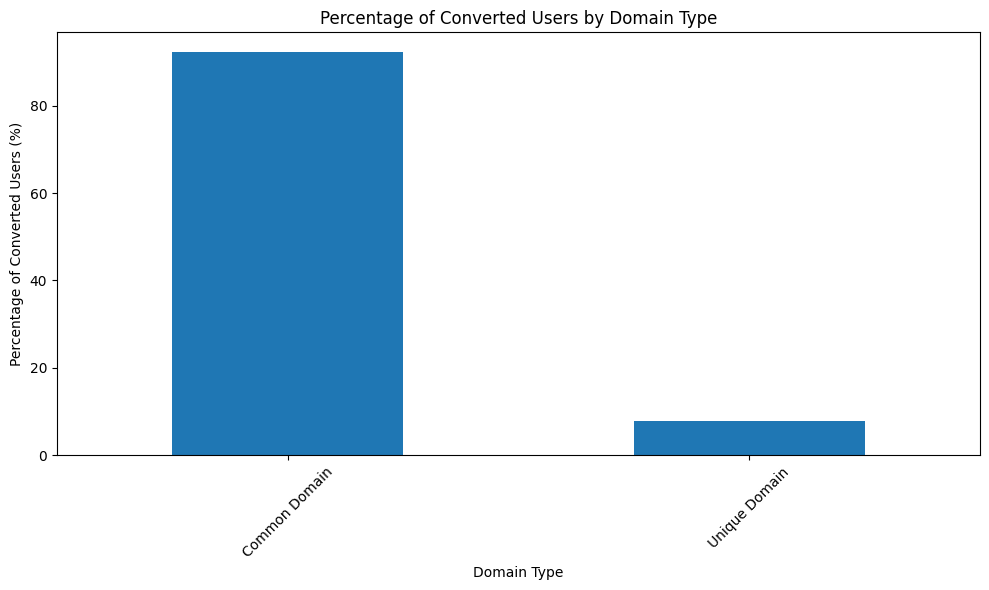

In [311]:
plot_conversion_rate(df, 'is_converted', 'Domain Type')

In [312]:
filtered_df = df[df['is_converted'] == True]

# Step 3: Calculate the mean of 's_onTime' for the filtered DataFrame
s_onTime_mean_filtered = filtered_df['Sum of Study Interests'].mean()
print(s_onTime_mean_filtered)

1.1147670569635888


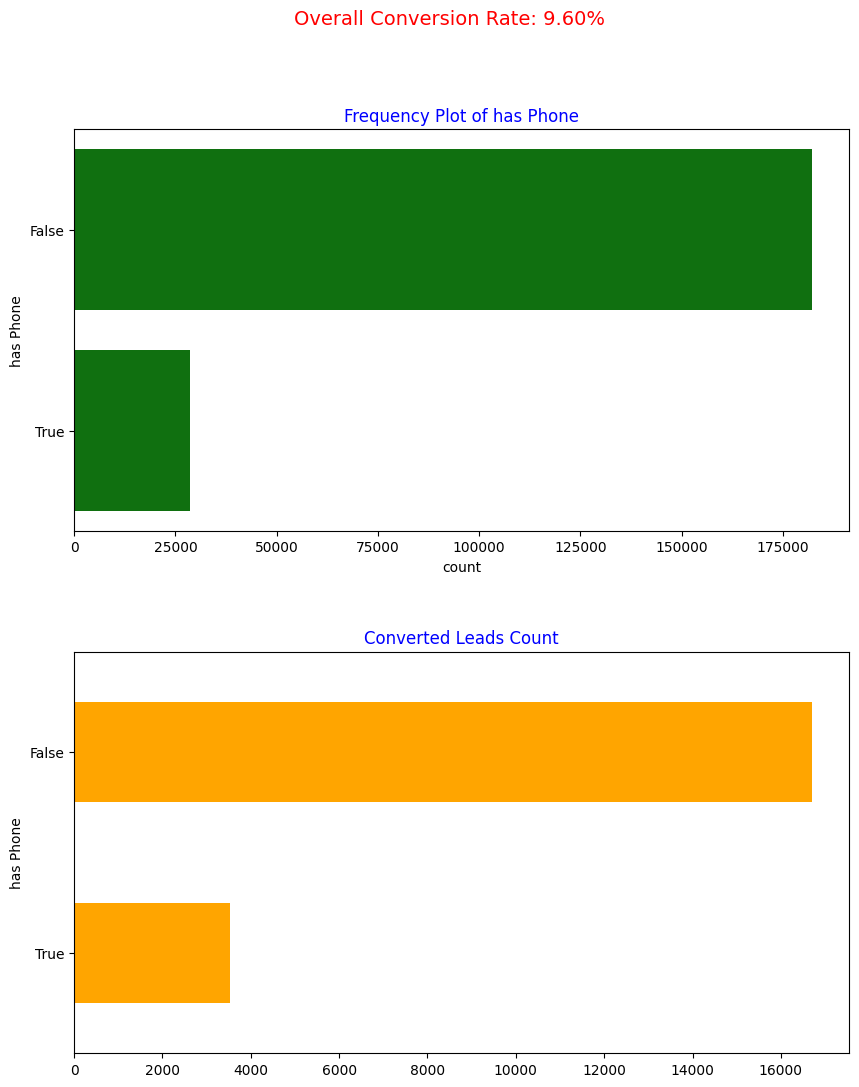

In [313]:
plot_frequency_and_percentage('has Phone', df, df, True, 6)

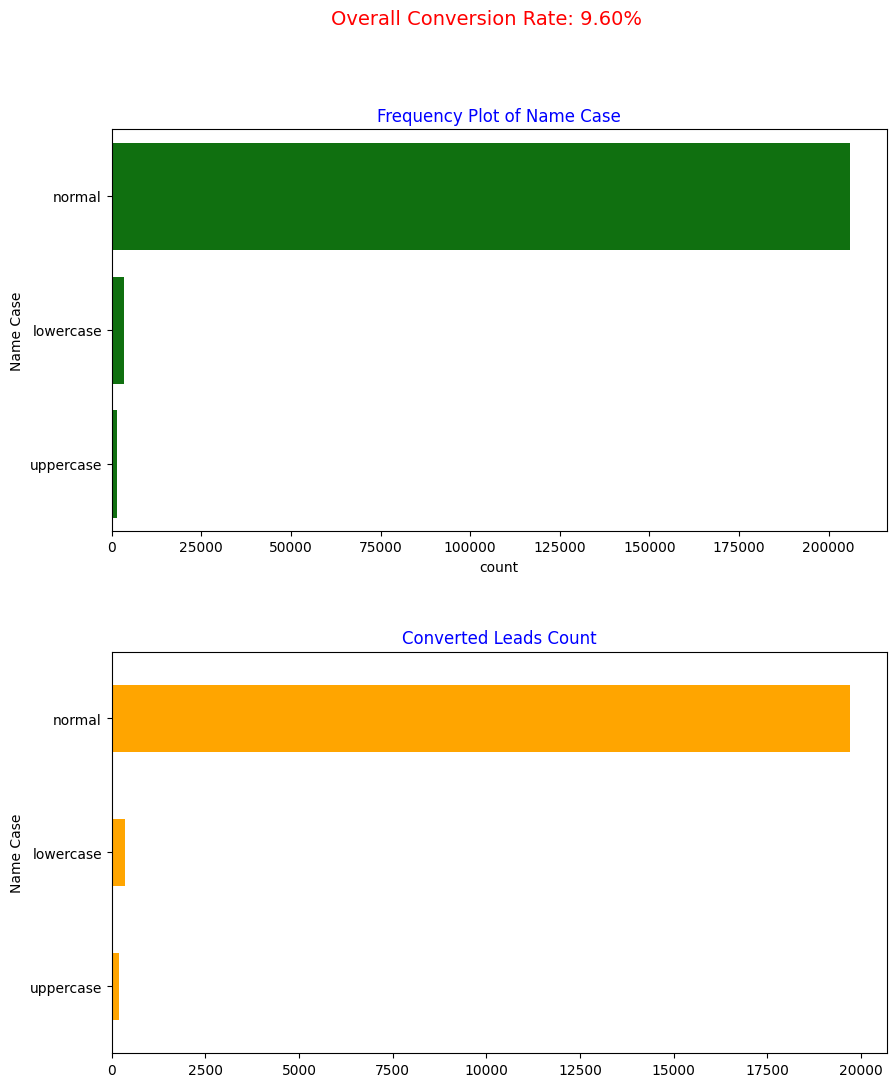

In [314]:
plot_frequency_and_percentage('Name Case', df, df, True, 6)

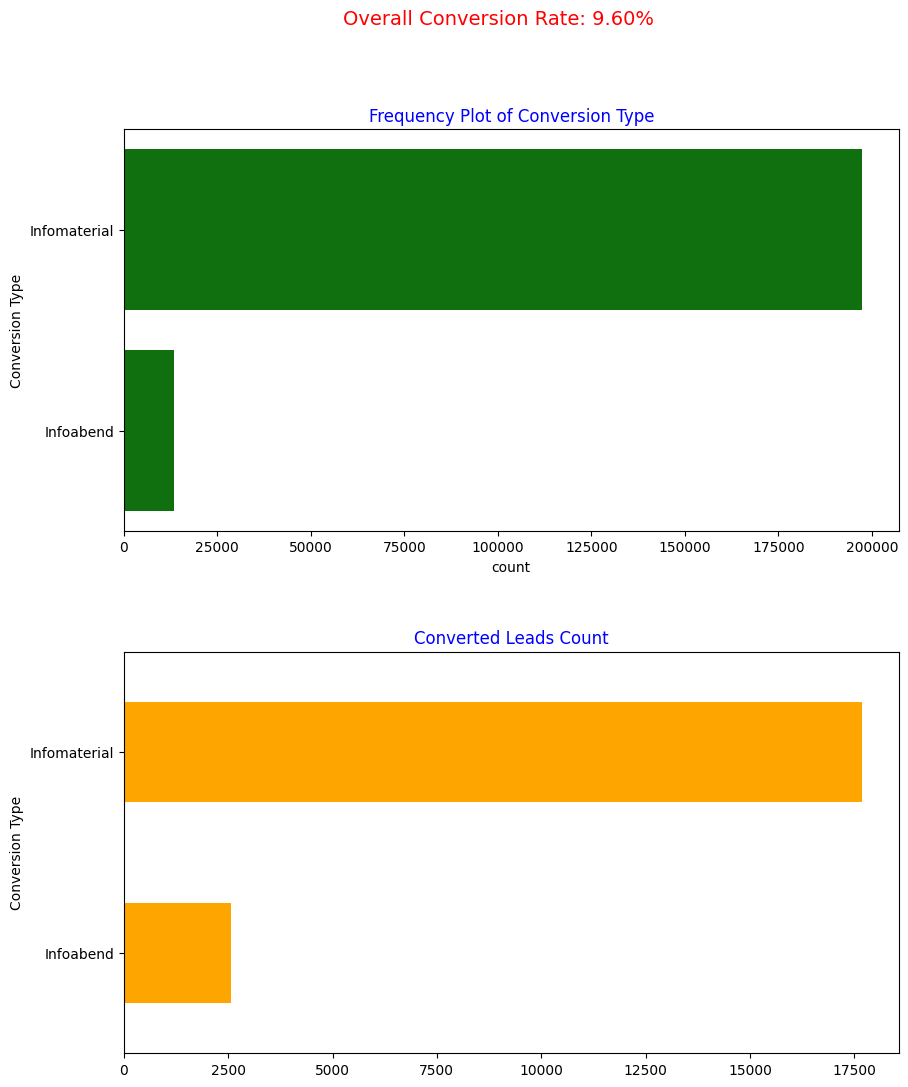

In [315]:
plot_frequency_and_percentage('Conversion Type', df, df, True, 6)

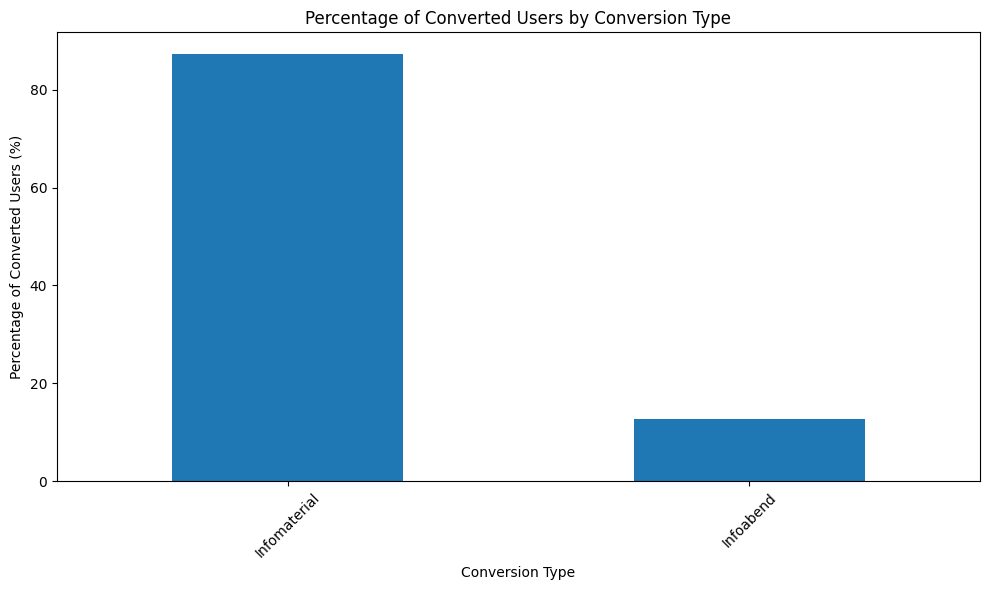

In [316]:
plot_conversion_rate(df, 'is_converted', 'Conversion Type')

In [317]:
! pip install category_encoders --q

In [318]:
# Import necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
import category_encoders as ce

In [319]:
df.dtypes

Lead Source                object
Lead Source Detail         object
Name Case                  object
Domain Type                object
Gender                     object
Host                       object
has Phone                 boolean
Accept Data Policy        boolean
Conversion Type            object
Study Model                object
Type of Study Program      object
Study Location             object
Faculty                    object
Study Program              object
Semester                   object
is_converted              boolean
Sum of Study Interests      Int64
dtype: object

In [320]:
df.nunique()

Lead Source                24
Lead Source Detail        505
Name Case                   3
Domain Type                 2
Gender                      4
Host                       11
has Phone                   2
Accept Data Policy          2
Conversion Type             2
Study Model                 5
Type of Study Program       6
Study Location             19
Faculty                    10
Study Program             192
Semester                    2
is_converted                2
Sum of Study Interests     11
dtype: int64

In [321]:
'''
# Define numerical types
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Identify categorical columns
categorical_columns = [col for col in df.columns if df[col].dtype not in numerics]

# Encode categorical columns
for col in categorical_columns:
        target_encoder = TargetEncoder()
        df[col] = target_encoder.fit_transform(df[col].astype(str))
        '''

"\n# Define numerical types\nnumerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']\n\n# Identify categorical columns\ncategorical_columns = [col for col in df.columns if df[col].dtype not in numerics]\n\n# Encode categorical columns\nfor col in categorical_columns:\n        target_encoder = TargetEncoder()\n        df[col] = target_encoder.fit_transform(df[col].astype(str))\n        "

In [322]:
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
# Define numerical types
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Identify categorical columns
categorical_columns = [col for col in df.columns if df[col].dtype not in numerics and col != 'is_converted']

# Ensure all categorical columns are treated as strings (if not already)
for col in categorical_columns:
    df[col] = df[col].astype(str)

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize TargetEncoder
target_encoder = TargetEncoder()

# Array to collect transformed data for all folds
transformed_dfs = []

# Cross-validation loop for encoding
for train_index, val_index in kf.split(df):
    train_df, val_df = df.iloc[train_index].copy(), df.iloc[val_index].copy()

    # Apply target encoding on training data
    for col in categorical_columns:
        target_encoder.fit(train_df[col], train_df['is_converted'])
        train_df[col] = target_encoder.transform(train_df[col])
        val_df[col] = target_encoder.transform(val_df[col])

    # Collect transformed data
    transformed_dfs.append(val_df)

# Concatenate all transformed validation folds
df_transformed = pd.concat(transformed_dfs, axis=0)

# Reset index to ensure proper alignment
df_transformed.reset_index(drop=True, inplace=True)


In [323]:

# Step 1: Drop 'is_converted' column from df_encoded and assign to X_
X = df_transformed.drop(columns=['is_converted'])

# Step 2: Extract 'is_converted' column from df_encoded and assign to y
y = df_transformed['is_converted']

In [324]:

lb = LabelEncoder()
lb.fit(y)
y_encoded = lb.transform(y)
print("Encoded labels:",lb.classes_)
y_en = pd.Series(y_encoded)

Encoded labels: [0. 1.]


In [325]:

# Step 6: Scaling the dataframe
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Step 7: Define the encoded and scaled dataframe as X_prep
X_prep = X_scaled

In [326]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_prep, y_en, test_size=0.3, stratify=y, random_state=42)


print("Training Data Shape : ", X_train.shape, y_train.shape)
print("Test Data Shape : ", X_temp.shape, y_temp.shape)

Training Data Shape :  (147557, 16) (147557,)
Test Data Shape :  (63240, 16) (63240,)


In [327]:
from imblearn.over_sampling import SMOTE


# Initialize SMOTENC with Nearest Neighbors Estimator
smote= SMOTE(random_state=42)

# Fit and resample the training data
X_train, y_train = smote.fit_resample(X_train, y_train)


In [328]:
print("Smote Train Data : ", X_train.shape, y_train.shape)

Smote Train Data :  (266776, 16) (266776,)


In [329]:
# Compute Mutual Information scores
mi_classification = mutual_info_classif(X_train, y_train, discrete_features='auto')

# Create a pandas Series with the MI scores and the feature names
mi_series = pd.Series(mi_classification, index=X_train.columns)

# Exclude the specified column
mi_series = mi_series.drop(labels='Sum of Study Interests')

# Sort the MI scores in descending order and convert to a DataFrame
data_mi = mi_series.sort_values(ascending=False).to_frame(name='MI')

# Display the DataFrame
print(data_mi)


                             MI
Study Program          0.379045
Study Location         0.347104
Lead Source Detail     0.297022
Lead Source            0.282932
Faculty                0.280868
Study Model            0.263604
Host                   0.253151
Accept Data Policy     0.250784
Type of Study Program  0.250526
Semester               0.246051
Name Case              0.242469
Domain Type            0.242307
Gender                 0.241374
Conversion Type        0.241016
has Phone              0.239778


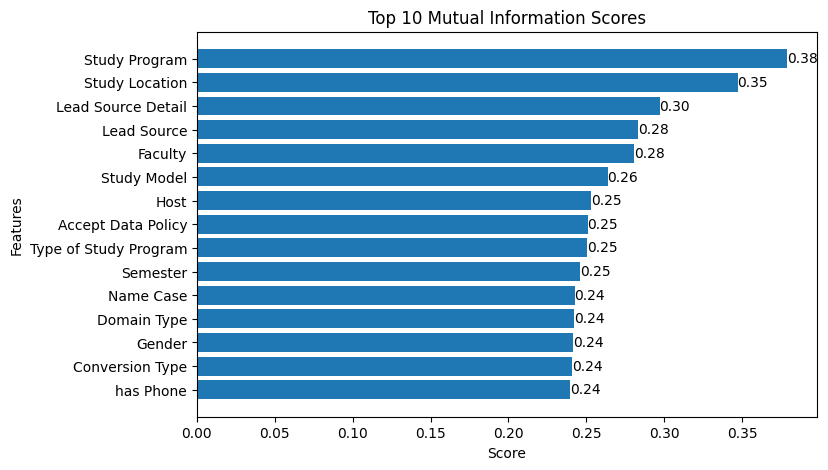

In [330]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the Mutual Information scores
def plot_mi_scores(scores):
    # Select top 10 scores
    top_scores = scores.sort_values(ascending=False).head(30)
    sorted_scores = top_scores.sort_values(ascending=True)
    width = np.arange(len(sorted_scores))
    ticks = sorted_scores.index
    plt.barh(width, sorted_scores)
    plt.yticks(width, ticks)
    plt.title("Top 10 Mutual Information Scores")
    plt.xlabel("Score")
    plt.ylabel("Features")

    # Add text annotations for the bar values
    for index, value in enumerate(sorted_scores):
        plt.text(value, index, f'{value:.2f}', va='center', ha='left')

    plt.show()

# Plot the Mutual Information scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_series)



In [331]:


# Filter data based on Mutual Information scores
filtered_data_mi = data_mi[data_mi['MI'] >= 0.01]

# Ensure indices match with X_train and X_temp columns
common_indices = filtered_data_mi.index.intersection(X_train.columns)
filtered_data_mi = filtered_data_mi.loc[common_indices]

# Apply the filtered indices to X_train and X_temp
X_train = X_train[common_indices]
X_temp = X_temp[common_indices]

In [332]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import f_classif
from scipy import stats

X = df[['Sum of Study Interests']]
y = df['is_converted']

# Apply ANOVA F-test
f_values, p_values = f_classif(X, y)

# Create a DataFrame to display the F-scores and p-values for the specific feature
anova_results = pd.DataFrame({
    'Feature': ['Sum of Study Interests'],
    'F-Score': f_values,
    'p-Value': p_values
})

# Select the feature (in this case, it's already just one)
selected_feature = anova_results.iloc[0]

print("Selected feature based on ANOVA F-test:")
print(selected_feature)

Selected feature based on ANOVA F-test:
Feature    Sum of Study Interests
F-Score                 993.49306
p-Value                       0.0
Name: 0, dtype: object


In [333]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [334]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_test)[:, 1]
    else:
        proba = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, proba)

    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall (Sensitivity): {recall}")
    print(f"F1-Score: {f1}")
    print(f"Specificity: {specificity}")
    print(f"ROC AUC: {roc_auc}")

    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

In [335]:
!pip install tensorflow>=2.15,<2.16 --q

/bin/bash: line 1: 2.16: No such file or directory


In [336]:
# Define the DNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
def create_dnn_model(input_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [337]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
# Pipelines for each model without hyperparameter tuning

pipeline_xgb = Pipeline([
    ('clf', xgb.XGBClassifier())
])

pipeline_rf = Pipeline([
    ('clf', RandomForestClassifier())
])


pipeline_dt = Pipeline([
    ('clf', DecisionTreeClassifier())
])

# For the DNN model, we need to specify the input dimension
input_dim = X_train.shape[1]
pipeline_dnn = Pipeline([
    ('clf', KerasClassifier(build_fn=lambda: create_dnn_model(input_dim), epochs=50, batch_size=32, verbose=0))
])


<ipython-input-337-33ee193ebbf0>:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('clf', KerasClassifier(build_fn=lambda: create_dnn_model(input_dim), epochs=50, batch_size=32, verbose=0))


In [338]:
model_performance = {}

XGBoost Metrics:
Accuracy: 0.8845983554712208
Precision: 0.24816176470588236
Recall (Sensitivity): 0.08706868752015479
F1-Score: 0.12890904750537122
Specificity: 0.9713173673691223
ROC AUC: 0.6747265374173799


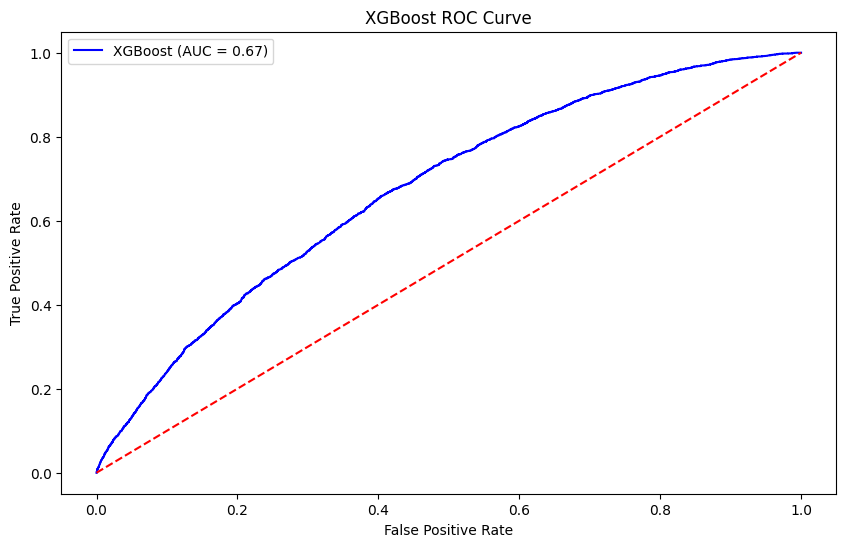

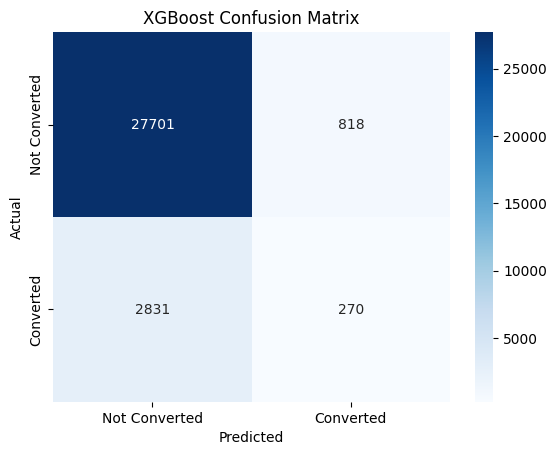

In [339]:
# Train and evaluate XGBoost
model_performance['XGBoost'] = evaluate_model(pipeline_xgb.fit(X_train, y_train), X_val, y_val, "XGBoost")

Random Forest Metrics:
Accuracy: 0.8584123972169513
Precision: 0.18029739776951673
Recall (Sensitivity): 0.1251209287326669
F1-Score: 0.14772510946126025
Specificity: 0.9381464988253445
ROC AUC: 0.6245468448146366


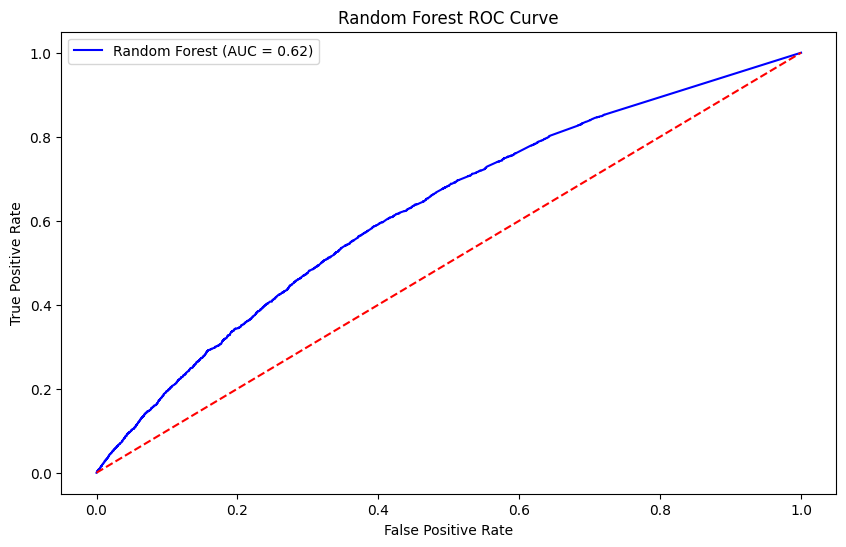

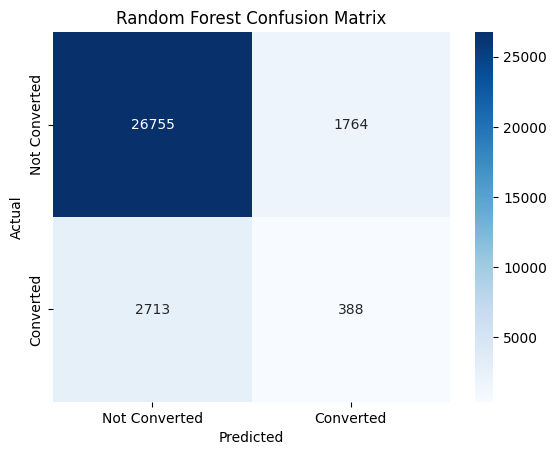

In [340]:
# Train and evaluate RandomForest
model_performance['Random Forest'] = evaluate_model(pipeline_rf.fit(X_train, y_train), X_val, y_val, "Random Forest")

Decision Tree Metrics:
Accuracy: 0.8448450347881088
Precision: 0.17430530494406352
Recall (Sensitivity): 0.15575620767494355
F1-Score: 0.16450953678474112
Specificity: 0.9197727830569095
ROC AUC: 0.5540918940657913


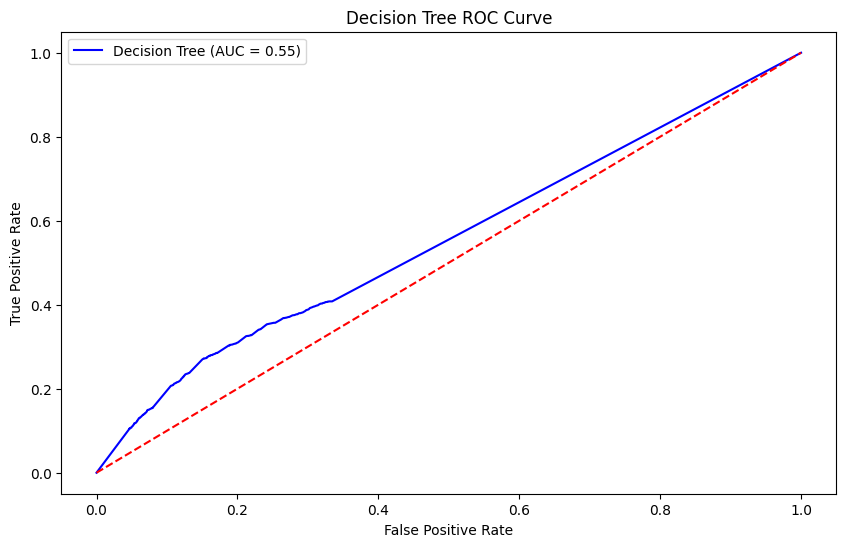

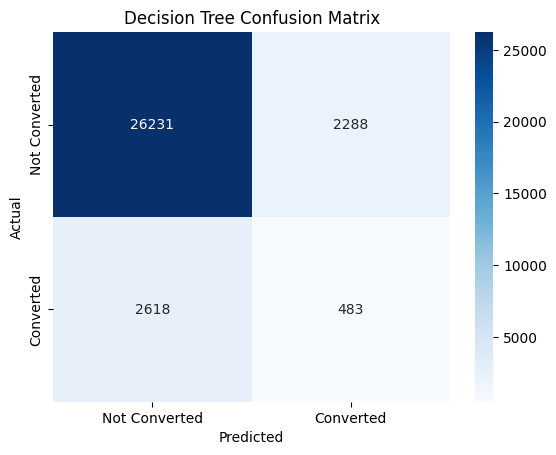

In [341]:
# Train and evaluate DecisionTree
model_performance['Decision Tree'] = evaluate_model(pipeline_dt.fit(X_train, y_train), X_val, y_val, "Decision Tree")

989/989 [==============================] - 1s 1ms/step
Deep Neural Network Metrics:
Accuracy: 0.6416824794433903
Precision: 0.1670308327263899
Recall (Sensitivity): 0.6655917445985166
F1-Score: 0.26704618967524907
Specificity: 0.639082716785301
ROC AUC: 0.7051813893392797


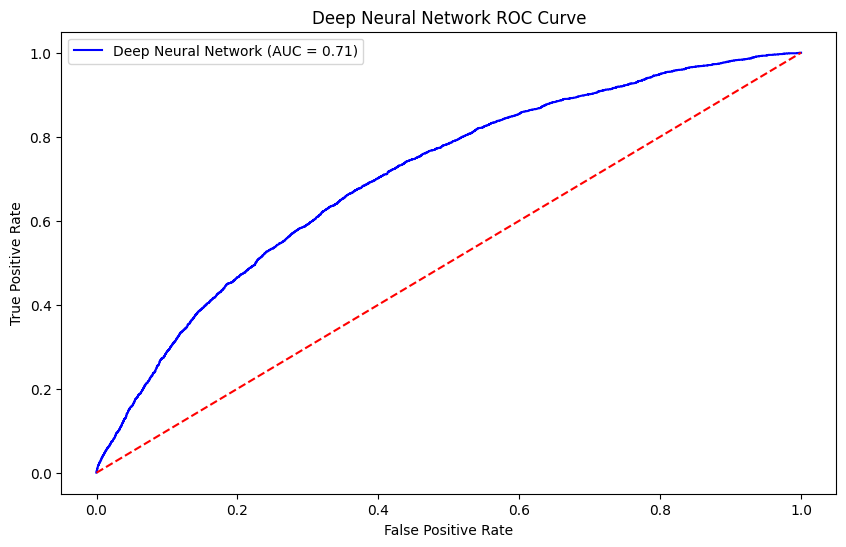

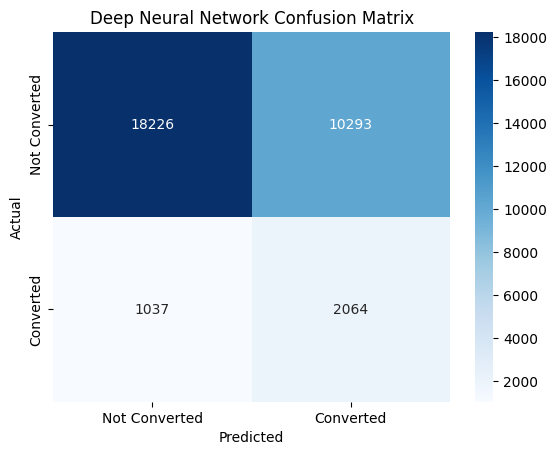

In [342]:
model_performance['DNN'] = evaluate_model(pipeline_dnn.fit(X_train, y_train), X_val, y_val, "Deep Neural Network")

In [343]:
# Print the performance metrics
for model_name, metrics in model_performance.items():
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


XGBoost Performance:
accuracy: 0.8846
precision: 0.2482
recall: 0.0871
f1: 0.1289
roc_auc: 0.6747
specificity: 0.9713

Random Forest Performance:
accuracy: 0.8584
precision: 0.1803
recall: 0.1251
f1: 0.1477
roc_auc: 0.6245
specificity: 0.9381

Decision Tree Performance:
accuracy: 0.8448
precision: 0.1743
recall: 0.1558
f1: 0.1645
roc_auc: 0.5541
specificity: 0.9198

DNN Performance:
accuracy: 0.6417
precision: 0.1670
recall: 0.6656
f1: 0.2670
roc_auc: 0.7052
specificity: 0.6391


In [344]:
# Convert the model performance dictionary to a DataFrame
results_df = pd.DataFrame(model_performance).T

# Save the DataFrame to an Excel file
results_df.to_excel('model_performance_results5.xlsx', index=True)
print("Model performance results saved to 'model_performance_results_final.xlsx'.")

Model performance results saved to 'model_performance_results_final.xlsx'.


In [345]:
 #Define hyperparameters for Grid Search
from scipy.stats import uniform, randint

# Define hyperparameters for Grid/Randomized Search
param_distributions_xgb = {
    'clf__max_depth': randint(3, 10),
    'clf__learning_rate': uniform(0.001, 0.1),
    'clf__n_estimators': randint(100, 500),
    'clf__subsample': uniform(0.6, 0.4),
    'clf__colsample_bytree': uniform(0.6, 0.4),
    'clf__gamma': uniform(0, 0.2),
    'clf__min_child_weight': randint(1, 6),
    'clf__reg_alpha': uniform(0, 0.5),
    'clf__reg_lambda': uniform(1, 2)
}

param_distributions_rf = {
    'clf__n_estimators': randint(100, 500),
    'clf__max_depth': [None] + list(range(10, 50, 10)),
    'clf__min_samples_split': randint(2, 11),
    'clf__min_samples_leaf': randint(1, 5),
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__bootstrap': [True, False]
}

param_distributions_dt = {
    'clf__max_depth': [None] + list(range(10, 50, 10)),
    'clf__min_samples_split': randint(2, 11),
    'clf__min_samples_leaf': randint(1, 5),
    'clf__max_features': ['auto', 'sqrt', 'log2']
}

param_distributions_dnn = {
    'clf__optimizer': ['adam', 'rmsprop'],
    'clf__dropout_rate': uniform(0, 0.5),
    'clf__neurons': randint(16, 128),
    'clf__batch_size': [16, 32, 64],
    'clf__epochs': [50, 100],
    'clf__activation': ['relu', 'tanh']
}

In [346]:

param_grid_xgb = {
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.1, 0.01],
    'clf__n_estimators': [100, 200]
}

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}

param_grid_dt = {
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 10, 20]
}

param_grid_dnn = {
    'clf__hidden_layer_sizes': [(50,50), (100,)],
    'clf__activation': ['tanh', 'relu'],
    'clf__solver': ['sgd', 'adam'],
    'clf__alpha': [0.0001, 0.05],
    'clf__learning_rate': ['constant', 'adaptive'],
}


In [347]:
def perform_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    return grid_search


In [348]:
from sklearn.model_selection import GridSearchCV
# Function to perform Randomized Search
def perform_randomized_search(pipeline, param_distributions, X_train, y_train, n_iter=100):
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                       n_iter=n_iter, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search

In [349]:
#from sklearn.experimental import enable_halving_random_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
# Function to perform Halving Randomized Search
def perform_halving_randomized_search(pipeline, param_distributions, X_train, y_train, n_iter=100):
    halving_random_search = HalvingRandomSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        resource='n_samples',  # Resource parameter for halving
        max_resources='auto',  # Use maximum available resources
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2,
        random_state=42
    )
    halving_random_search.fit(X_train, y_train)
    return halving_random_search


In [355]:

# Function to evaluate model using the test data
def evaluate_model(grid_search, X_test, y_test, model_name):
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall (Sensitivity): {recall}")
    print(f"F1-Score: {f1}")
    print(f"Specificity: {specificity}")
    print(f"ROC AUC: {roc_auc}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix Visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity,
        'best_params': grid_search.best_params_
    }

In [356]:
model_performance = {}

In [357]:
grid_search_xgb = perform_grid_search(pipeline_xgb, param_grid_xgb, X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


XGBoost Metrics:
Accuracy: 0.8829854522454142
Precision: 0.2476832350463353
Recall (Sensitivity): 0.09480812641083522
F1-Score: 0.1371268656716418
Specificity: 0.9686875416389074
ROC AUC: 0.6808107606577709


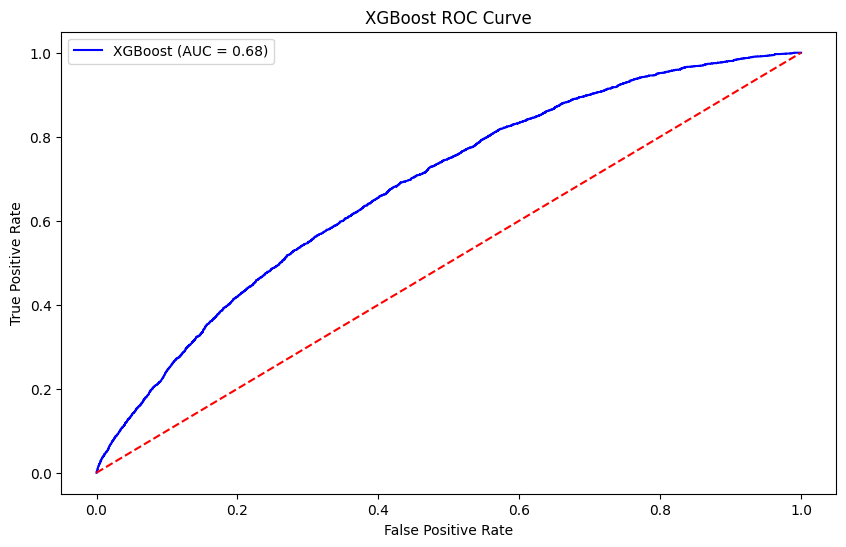

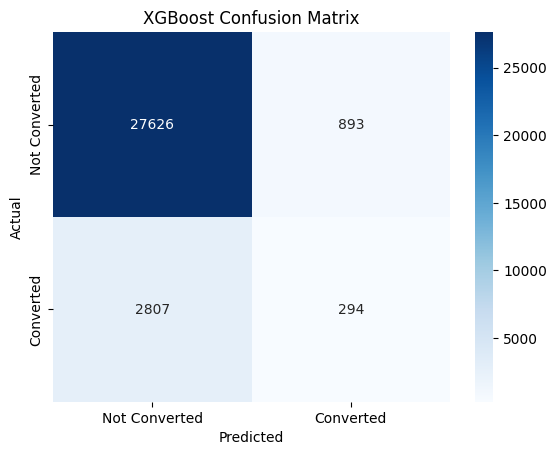

In [358]:
model_performance['XGBoost'] = evaluate_model(grid_search_xgb.best_estimator_, X_val, y_val, "XGBoost")

In [ ]:
k

In [353]:
random_search_xgb = perform_halving_randomized_search(pipeline_xgb, param_distributions_xgb, X_train, y_train)

n_iterations: 9
n_required_iterations: 9
n_possible_iterations: 9
min_resources_: 20
max_resources_: 266776
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 13338
n_resources: 20
Fitting 5 folds for each of 13338 candidates, totalling 66690 fits


KeyboardInterrupt: 

In [ ]:
model_performance['XGBoost'] = evaluate_model(random_search_xgb.best_estimator_, X_val, y_val, "XGBoost")

In [ ]:
random_search_rf = perform_randomized_search(pipeline_rf, param_distributions_rf, X_train, y_train)

In [ ]:
model_performance['RandomForest'] = evaluate_model(random_search_rf.best_estimator_, X_val, y_val, "RandomForest")

In [ ]:
random_search_dt = perform_randomized_search(pipeline_dt, param_distributions_dt, X_train, y_train)

In [ ]:
model_performance['DecisionTree'] = evaluate_model(random_search_dt.best_estimator_, X_val, y_val, "DecisionTree")

In [ ]:
random_search_dnn = perform_randomized_search(pipeline_dnn, param_distributions_dnn, X_train, y_train)

In [ ]:
model_performance['DNN'] = evaluate_model(random_search_dnn.best_estimator_, X_val, y_val, "Deep Neural Network")

In [ ]:
# Print the performance metrics
for model_name, metrics in model_performance.items():
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

In [ ]:
# Convert the model performance dictionary to a DataFrame
results_df = pd.DataFrame(model_performance).T

# Save results to an Excel file
results_df.to_excel('model_performance_metrics_final.xlsx', index=True)

# Print results for each model
print("Model Performance Metrics:")
print(results_df)
